In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pickle
import scipy.stats
from tqdm import tqdm_notebook
from sklearn.decomposition import IncrementalPCA 
from helpers.data_generator import process_data
import seaborn as sns

Using TensorFlow backend.


In [2]:
## This just sets up some plotting preferences
%matplotlib inline
font={'family': 'DejaVu Serif',
      'size': 12}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

In [4]:
# Load in the data. 
# rawdata is a dictionary, the keys are shot #s, and the values are sub-dictionaries of signal names and np arrays
data_path = '/scratch/gpfs/jabbate/mixed_data/final_data_batch_154.pkl'
rawdata = {}
with open(data_path,'rb') as f:
    rawdata.update(pickle.load(f, encoding='latin1'))
len(rawdata.keys())

50

In [6]:
rawdata.keys()

dict_keys([171136, 171137, 171138, 171139, 171140, 171141, 171142, 171143, 171144, 171145, 171146, 171147, 171148, 171149, 171165, 171167, 171168, 171169, 171170, 171171, 171172, 171173, 171174, 171175, 171176, 171177, 171178, 171179, 171180, 171181, 171182, 171183, 171184, 171186, 171187, 171188, 171196, 171198, 171199, 171200, 171201, 171203, 171204, 171205, 171206, 171207, 171208, 171209, 171211, 171212])

In [70]:
## This lists all the available signals
keys = list(rawdata[list(rawdata.keys())[0]].keys())
keys.sort()
keys

['C_coil_139',
 'C_coil_19',
 'C_coil_199',
 'C_coil_259',
 'C_coil_319',
 'C_coil_79',
 'C_coil_method',
 'C_coil_nonstandard_139',
 'C_coil_nonstandard_199',
 'C_coil_nonstandard_79',
 'F_coil_1a',
 'F_coil_1b',
 'F_coil_2a',
 'F_coil_2b',
 'F_coil_3a',
 'F_coil_3b',
 'F_coil_4a',
 'F_coil_4b',
 'F_coil_5a',
 'F_coil_5b',
 'F_coil_6a',
 'F_coil_6b',
 'F_coil_7a',
 'F_coil_7b',
 'F_coil_8a',
 'F_coil_8b',
 'F_coil_9a',
 'F_coil_9b',
 'I_coil_150L',
 'I_coil_150U',
 'I_coil_210L',
 'I_coil_210U',
 'I_coil_270L',
 'I_coil_270U',
 'I_coil_30L',
 'I_coil_30U',
 'I_coil_330L',
 'I_coil_330U',
 'I_coil_90L',
 'I_coil_90U',
 'I_coil_method',
 'I_coil_nonstandard_150',
 'I_coil_nonstandard_30',
 'I_coil_nonstandard_90',
 'a_EFIT01',
 'a_EFIT02',
 'a_EFITRT1',
 'a_EFITRT2',
 'beam_feedback_power_target_quantity',
 'beam_feedback_power_target_value',
 'beam_feedback_switch',
 'beam_feedback_torque_target_quantity',
 'beam_feedback_torque_target_value',
 'beam_target_power',
 'beam_target_torque

In [71]:
## This processes the raw data into a form suitable for training
# does some averaging, normalizing, groups into training samples
# can play around with what actuators/profiles to use
actuator_names = ['pinj','tinj','curr','gasA']
profile_names = ['temp','dens','press_EFIT02','rotation','ffprime_EFIT02','q_EFIT02']
sig_names = actuator_names + profile_names
normalization_method = 'RobustScaler'
lookbacks = {}
actuator_lookback = 6
for sig in actuator_names:
    lookbacks[sig] = actuator_lookback
for sig in profile_names:
    lookbacks[sig] = 1
lookahead = 3
sample_step=1
window_overlap=0
window_length=1
uniform_normalization=True
data, valdata, normalization_params = process_data(rawdata, sig_names, normalization_method, window_length,
                                                    window_overlap, lookbacks, lookahead, sample_step,
                                                    uniform_normalization, train_frac=0.8, val_frac=0.2,
                                                    nshots=12000,verbose=1, flattop_only=True)

Gathering:   2%|2         | 1/46 [00:00<00:08,  5.10it/s]

Signals: curr, dens, ffprime_EFIT02, gasA, pinj, press_EFIT02, q_EFIT02, rotation, temp, tinj
Number of useable shots:  46
Number of shots used:  46
Total number of timesteps:  12314


Stacking:  42%|####2     | 8/19 [00:00<00:00, 79.18it/s]

Shots with Complete NaN: [171187.]


Removing ECH:   4%|3         | 138/3665 [00:00<00:02, 1373.89it/s]

8275 samples total


Removing ECH: 100%|##########| 3665/3665 [00:02<00:00, 1713.27it/s]
Removing weird gas: 0it [00:00, ?it/s]
Normalizing:  68%|######8   | 13/19 [00:00<00:00, 114.12it/s]

Removed 3972 samples
4303 samples remaining
Removed 0 samples
4303 samples remaining
4303 samples remaining after pruning


Splitting: 100%|##########| 19/19 [00:00<00:00, 1402.65it/s]

Total number of samples:  4303
Number of training samples:  3442
Number of validation samples:  861


In [72]:
# split into I/O pairs
X = {sig: data[sig][:,0,:].T for sig in profile_names} # State at t
Y = {sig: data[sig][:,-1,:].T for sig in profile_names} # state at t+1
U = {sig: data[sig].T for sig in actuator_names} # contol inputs
# validation data
Xval = {sig: valdata[sig][:,0,:].T for sig in profile_names}
Yval = {sig: valdata[sig][:,-1,:].T for sig in profile_names}
Uval = {sig: valdata[sig].T for sig in actuator_names}

In [73]:
# take SVD of inputs
svd = {}
for sig in tqdm_notebook(X.keys(), position=0):
    U1,S,V = np.linalg.svd(X[sig], full_matrices=False)
    svd[sig + '_U'] = U1
    svd[sig + '_S'] = S
    svd[sig + '_V'] = V
    svd[sig + '_percentile'] = np.cumsum(S)/np.sum(S)

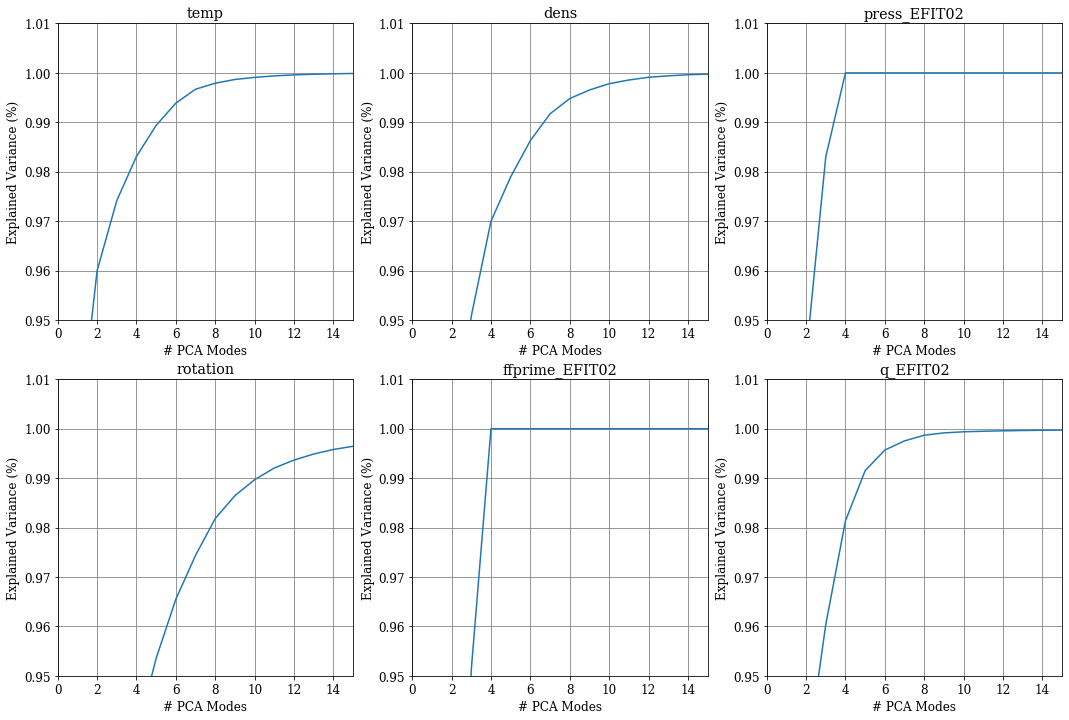

In [74]:
# plot singular values to see how many modes to keep for reduced order model
nrows = 2
ncols = 3
figsize = (ncols*6,nrows*6)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
for i, sig in tqdm_notebook(enumerate(profile_names)):
    ax = axes[np.unravel_index(i,(nrows,ncols))]
    ax.plot(svd[sig+'_percentile'])
    ax.title.set_text(sig)
    ax.set_ylim([.95,1.01])
    ax.set_xlim([0,15])
    ax.yaxis.grid(color='gray')
    ax.xaxis.grid(color='gray')
    ax.set_xlabel('# PCA Modes')
    ax.set_ylabel('Explained Variance (%)')

In [75]:
# extract PCA modes
kernels= {}
pca_modes = {}
nmodes = {}
var_cutoff = .99
for sig in profile_names:
    nmodes[sig] = np.nonzero(svd[sig + '_percentile']>var_cutoff)[0][1]
    pca_modes[sig] = svd[sig + '_U'][:,0:nmodes[sig]].T
    kernels[sig] = np.matmul(pca_modes[sig],pca_modes[sig].T)

In [76]:
# form input/output matrices of PCA modes
Xpca = np.concatenate([np.matmul(np.diag(svd[sig + '_S']),
                                 svd[sig + '_V'])[0:nmodes[sig],:] for sig in profile_names],axis=0)
Ypca = np.concatenate([np.matmul(pca_modes[sig],Y[sig]) for sig in profile_names],axis=0)
Upca = np.concatenate([U[sig] for sig in actuator_names],axis=0)

In [77]:
# pinvert input matrix
XU = np.concatenate([Xpca,Upca],axis=0)
XUinv = np.linalg.pinv(XU)

Text(0.5, 1, 'B')

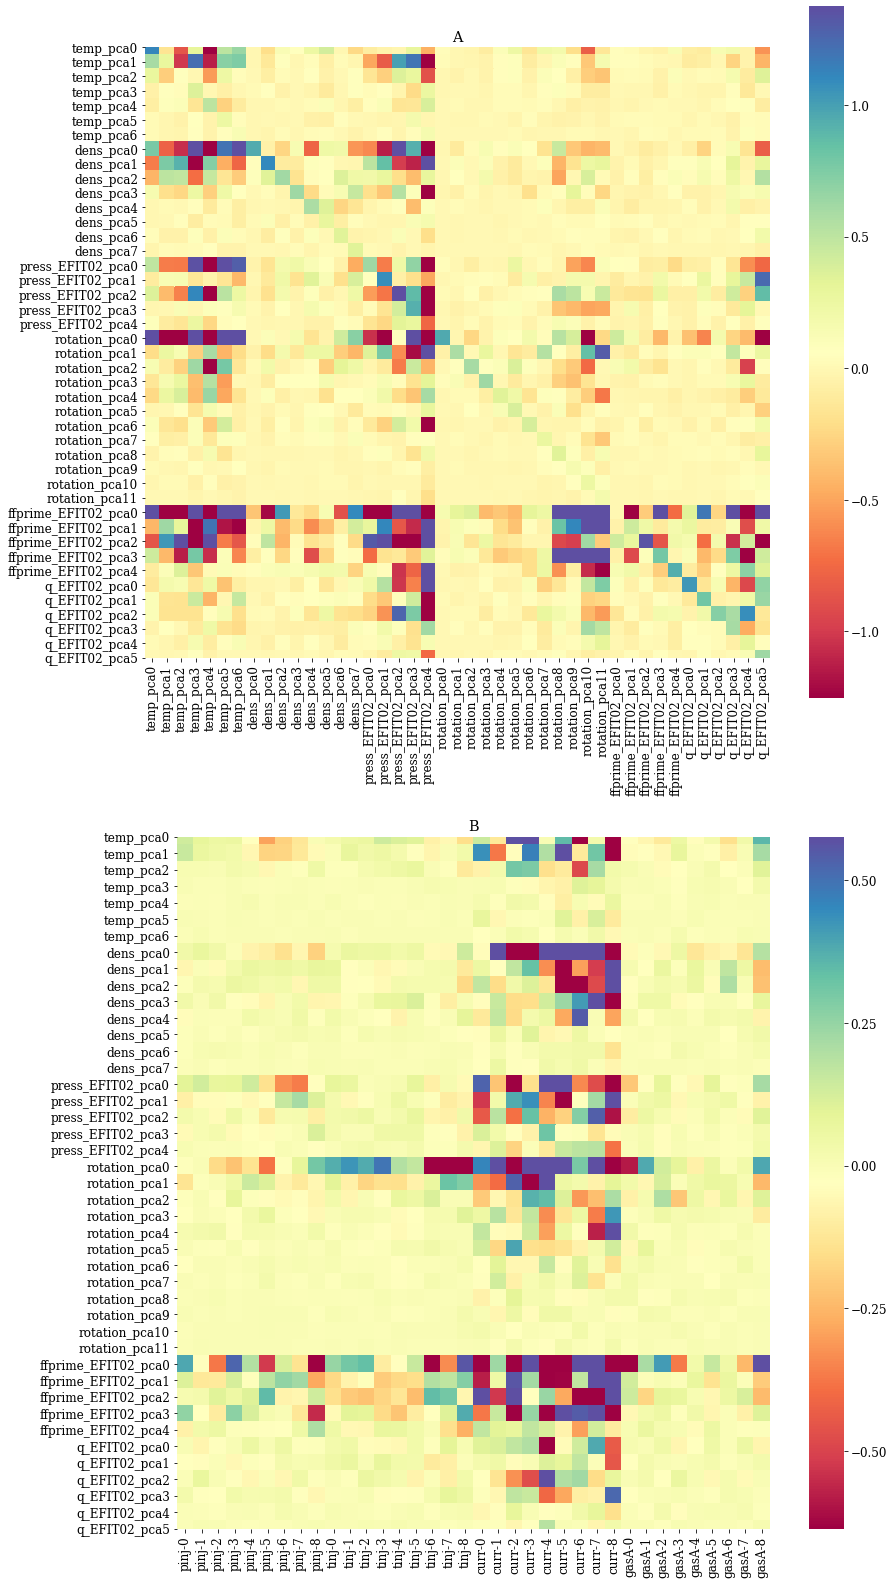

In [78]:
# get A,B matrices
AB = np.matmul(Ypca,XUinv)
A = AB[:,0:Xpca.shape[0]]
B = AB[:,Xpca.shape[0]:]
f, axes = plt.subplots(2, 1, figsize=(14, 28))
Aylabel = [sig + '_pca' + str(i) for sig in profile_names for i in range(nmodes[sig]) ]
Axlabel = Aylabel
Bylabel = Aylabel
Bxlabel = [sig + '-' + str(i) for sig in actuator_names for i in range(actuator_lookback + lookahead) ]
cmap='Spectral'
sns.heatmap(A, cmap=cmap, annot=False, square=True, robust=True, 
            xticklabels = Axlabel, yticklabels = Aylabel, ax=axes[0]).set_title('A')
sns.heatmap(B, cmap=cmap, annot=False, square=True, robust=True, 
            xticklabels = Bxlabel, yticklabels = Bylabel, ax=axes[1]).set_title('B')


Text(0, 0.5, 'Im($\\lambda$)')

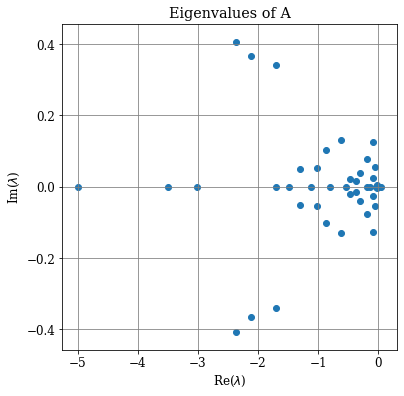

In [84]:
## Plot spectrum of A
eigvals, eigvecs = np.linalg.eig(A)
eigvals = np.log(eigvals)
plt.figure(figsize=(6,6))
plt.scatter(np.real(eigvals),np.imag(eigvals))
plt.title('Eigenvalues of A')
plt.grid(color='gray')
plt.xlabel('Re($\lambda$)')
plt.ylabel('Im($\lambda$)')

In [85]:
## Define some stuff
class linear_model():
    def __init__(self,A,B,pca_modes,profile_names,actuator_names):
        self.A = A
        self.B = B
        self.pca_modes = pca_modes
        self.profile_names = profile_names
        self.actuator_names = actuator_names
        self.which_modes = {}
        i=0
        for sig in self.profile_names:
            self.which_modes[sig] = np.arange(i,i+self.pca_modes[sig].shape[0])
            i = self.which_modes[sig][-1]+1
            
    def predict_on_batch(self,inputs=None, X=None, U=None):
        if inputs is not None and X is None and U is None:
            xinput = np.concatenate([np.matmul(self.pca_modes[sig],inputs[sig]) for sig in self.profile_names])
            uinput = np.concatenate([inputs[sig] for sig in self.actuator_names])
        elif inputs is not None and X is not None and U is None:
            xinput = np.concatenate([np.matmul(self.pca_modes[sig],inputs[sig]) for sig in self.profile_names])
            uinput = np.concatenate([X[sig] for sig in self.actuator_names])
        elif inputs is None and X is not None and U is not None:
            xinput = np.concatenate([np.matmul(self.pca_modes[sig],X[sig]) for sig in self.profile_names])
            uinput = np.concatenate([U[sig] for sig in self.actuator_names])
        else:
            raise ValueError("Must provide either input dictionary or seperate X and U inputs")
        youtput = np.matmul(self.A,xinput) + np.matmul(self.B,uinput)
        prediction = {sig: np.matmul(self.pca_modes[sig].T,youtput[self.which_modes[sig]])
                       for i, sig in enumerate(self.profile_names)}
        return prediction

In [86]:
## Create a model and make some predictions
model = linear_model(A,B,pca_modes,profile_names,actuator_names)
predictions = model.predict_on_batch(X,U)
# predict with input perturbed
predictions_perturbed = model.predict_on_batch(X,{key:val+.5 for key,val in U.items()})

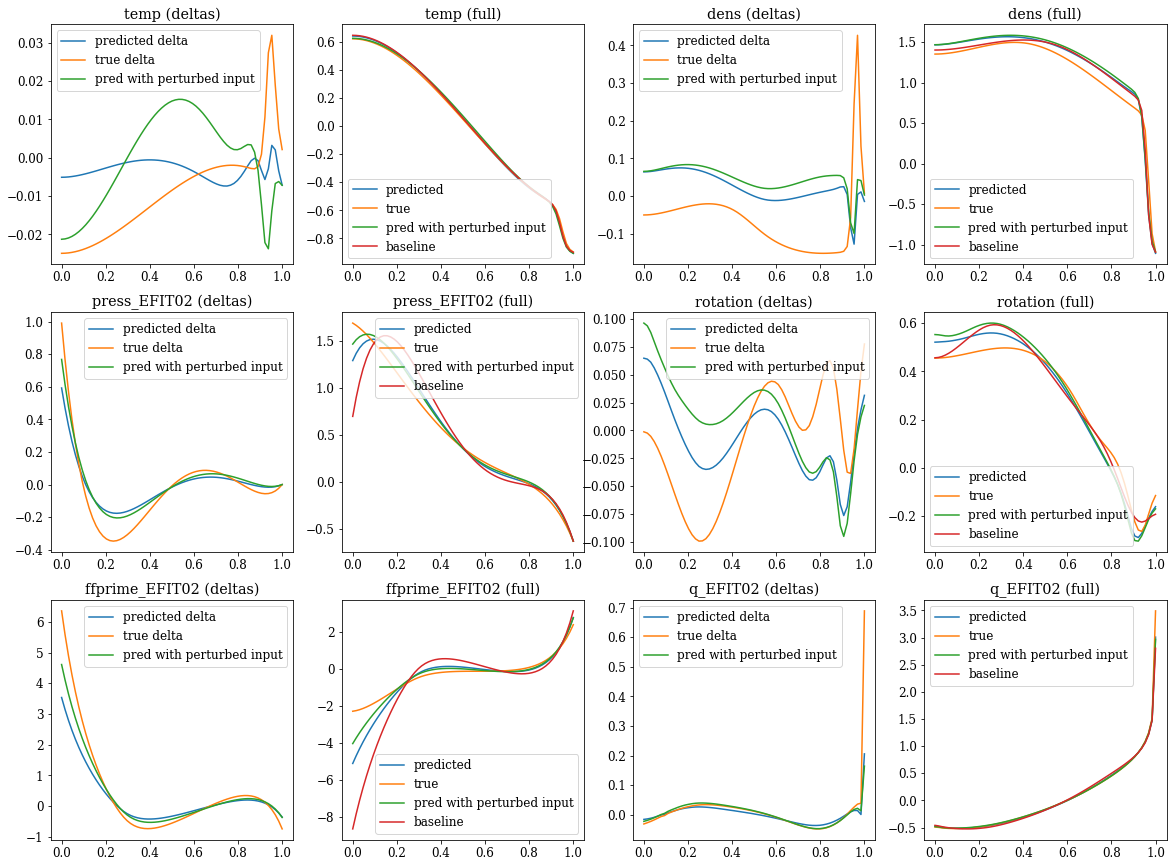

In [87]:
# test: get a set of inputs, predict output, and project back onto PCA
idx = 150
baseline = {sig: X[sig][:,idx] for sig in profile_names}
true = {sig: Y[sig][:,idx] for sig in profile_names}
pred = {sig: predictions[sig][:,idx] for sig in profile_names}
pred_pert = {sig: predictions_perturbed[sig][:,idx] for sig in profile_names}

#plot
psi = np.linspace(0,1,65)
figsize = (4*5,3*5)
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=figsize)
for i, sig in tqdm_notebook(enumerate(profile_names)):
        ax[np.unravel_index(2*i,(3,4))].plot(psi,pred[sig]-baseline[sig],
                                             psi,true[sig]-baseline[sig],psi,pred_pert[sig]-baseline[sig])
        ax[np.unravel_index(2*i,(3,4))].title.set_text(sig + ' (deltas)')
        ax[np.unravel_index(2*i,(3,4))].legend(['predicted delta','true delta','pred with perturbed input'])
        ax[np.unravel_index(2*i+1,(3,4))].plot(psi,pred[sig],psi,true[sig],
                                               psi,pred_pert[sig],psi, baseline[sig])
        ax[np.unravel_index(2*i+1,(3,4))].title.set_text(sig + ' (full)')
        ax[np.unravel_index(2*i+1,(3,4))].legend(['predicted','true','pred with perturbed input','baseline'])